In [1]:
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [4]:
from keras import backend as K

Using TensorFlow backend.


In [5]:
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.metrics import mean_squared_error

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
airport = pd.read_csv("search_sample_data/airports.csv")

In [10]:
watch_sample_full = pd.read_csv("search_sample_data/watch_sample.csv")

In [11]:
date_cols =['departure_date',
'return_date',
'first_searched_dt',
'watch_added_dt',
'latest_status_change_dt',
'first_buy_dt',
'last_notif_dt',
'forecast_last_warning_date',
'forecast_last_danger_date']

In [12]:
for col in date_cols:
    watch_sample_full[col] = pd.to_datetime(watch_sample_full[col])

In [13]:
watch_sample_full.shape

(1168145, 40)

# Understanding Origins

In [14]:
origin_data = watch_sample_full[['user_id','origin']].merge(airport[['location_id', 'airport_group']], left_on='origin',right_on='location_id')

In [15]:
origin_group_count = origin_data.groupby('user_id')['airport_group'].agg(['nunique']).reset_index()

In [16]:
user_count = watch_sample_full.groupby('user_id')['user_id'].agg(['size']).reset_index() 

In [17]:
user_count.head()

,user_id,size
0,0001ca3152611b9c7ead6bf33fe6279cd80059efa64441...,6
1,0003417097ef37b45bdd155b2aac72f876f80749a89c05...,2
2,00045f806866b778aa6222fbfe8280a9a510b3ffe939ac...,3
3,0005050da7f3ee662a8ea21856d9556621fd61f8a2a1f6...,1
4,00088669cc5838368a538c649658d9765f9a0ad8e2991e...,1


In [18]:
user_totalcount_origincount = origin_group_count.merge(user_count, on='user_id')

In [19]:
def ori_fraction(x):
    if x['nunique']==1:
        return 0
    else:
        return x['nunique']/x['size']

In [20]:
user_totalcount_origincount['origin_fraction'] = user_totalcount_origincount.apply(ori_fraction,axis=1)

In [21]:
one_origin_users = list(user_totalcount_origincount[(user_totalcount_origincount['origin_fraction']<=0.2)]['user_id'])

In [22]:
multi_origin_users = list(user_totalcount_origincount[(user_totalcount_origincount['origin_fraction']>0.2)]['user_id'])

In [23]:
len(one_origin_users), len(multi_origin_users),len(watch_sample_full['user_id'].unique())

(57963, 17037, 75000)

In [24]:
del user_totalcount_origincount, origin_group_count, user_count, origin_data

In [25]:
# Most of the users are one origins and logically too origin depends upon current location. 

In [26]:
watch_sample_full  =watch_sample_full.loc[:500000,:]

In [27]:
watch_sample_origin = watch_sample_full.merge(airport[['location_id', 'airport_group']], left_on='origin', right_on='location_id')

In [29]:
watch_sample_filtered = watch_sample_origin.drop(['origin','first_searched_dt','first_buy_dt','last_notif_dt','latest_status_change_dt','location_id'],axis=1)

In [30]:
import gc

In [31]:
gc.collect()

7

In [32]:
del watch_sample_origin, watch_sample_full

# Data Creation for making a model

Input : Observation by a user for a trip

Output: Same user trip which is coverted (active or booked)

In [33]:
self_joined_data = watch_sample_filtered.merge(watch_sample_filtered, on='user_id')

In [34]:
self_joined_data.head()

,user_id,trip_id_x,trip_type_x,destination_x,origin_type_x,destination_type_x,departure_date_x,return_date_x,stay_x,weekend_x,...,forecast_last_good_price_y,forecast_last_warning_date_y,forecast_last_danger_date_y,forecast_min_target_price_y,forecast_max_target_price_y,forecast_min_good_price_y,forecast_max_good_price_y,first_advance_y,watch_advance_y,airport_group_y
0,945e05e2b2510be2edb1149348fdb24852f2a6fe101e6c...,ddc5e806-226f-335d-a9f9-e59c55550832,one_way,airport/EWR,airport,airport,2018-03-01,NaT,NaN,0,...,245.0,2017-12-02,2018-01-18,406.0,491.0,245.0,248.0,3,3.0,airport/BCN
1,945e05e2b2510be2edb1149348fdb24852f2a6fe101e6c...,ddc5e806-226f-335d-a9f9-e59c55550832,one_way,airport/EWR,airport,airport,2018-03-01,NaT,NaN,0,...,267.0,2018-01-18,2018-02-08,452.0,452.0,267.0,267.0,2,NaN,airport/BCN
2,945e05e2b2510be2edb1149348fdb24852f2a6fe101e6c...,ddc5e806-226f-335d-a9f9-e59c55550832,one_way,airport/EWR,airport,airport,2018-03-01,NaT,NaN,0,...,73.0,2017-10-30,2018-03-01,217.0,217.0,73.0,73.0,0,NaN,airport/BCN
3,945e05e2b2510be2edb1149348fdb24852f2a6fe101e6c...,ddc5e806-226f-335d-a9f9-e59c55550832,one_way,airport/EWR,airport,airport,2018-03-01,NaT,NaN,0,...,342.0,2017-10-30,2018-05-11,436.0,436.0,342.0,342.0,130,NaN,airport/MIA
4,945e05e2b2510be2edb1149348fdb24852f2a6fe101e6c...,ddc5e806-226f-335d-a9f9-e59c55550832,one_way,airport/EWR,airport,airport,2018-03-01,NaT,NaN,0,...,323.0,2017-12-04,2018-05-15,394.0,394.0,323.0,323.0,39,NaN,city/WAS


In [35]:
del watch_sample_filtered

Trip id should not be same , otherwise input and output will be same

Last status for output should be either booked or active, (desired trips to recommned)

Origin of trips are same, we can recommend from same origin where user is now

Difference is flying date is less than 15 days either side.

In [36]:
def useful_data(df):
    df = df[df['trip_id_x']!=df['trip_id_y']]
    df = df[df['status_latest_y'].isin(['booked','active'])]
    df = df[df['airport_group_x']==df['airport_group_y']]
    df = df[df['destination_x']!=df['destination_y']]
    df = df[(abs((df['departure_date_x']-df['departure_date_y'])/ np.timedelta64(1,'D'))<15)]
    return df

In [37]:
tranformed_data = useful_data(self_joined_data)

In [38]:
tranformed_data.shape

(4284, 71)

In [39]:
tranformed_data['departure_date_from_2015'] = ((tranformed_data['departure_date_y'] - pd.to_datetime('01/01/2015', format='%m/%d/%Y'))/ np.timedelta64(1,'D')).astype('int32')

In [40]:
tranformed_data['departure_date_from_2015'].head()

17408    1294
17429    1294
17627    1286
37660    1310
37948    1310
Name: departure_date_from_2015, dtype: int32

In [41]:
# One way Features

In [42]:
input_features = ['destination_x' ,'destination_type_x','weekend_x', 'filter_no_lcc_x',
       'filter_non_stop_x', 'filter_short_layover_x', 'filter_name_x' , 'stay_x'
    ,'total_notifs_x','total_buy_notifs_x', 'first_rec_x', 'first_price_x' ,'first_buy_price_x', 
    'lowest_price_x'
   ,'forecast_first_target_price_x', 'forecast_first_good_price_x',
       'forecast_last_target_price_x', 'forecast_last_good_price_x',
       'forecast_min_target_price_x', 'forecast_max_target_price_x',
       'forecast_min_good_price_x', 'forecast_max_good_price_x',
       'first_advance_x', 'watch_advance_x'] 

output_features= ['destination_y','departure_date_from_2015', 'stay_y']

In [43]:
input_data = tranformed_data[input_features]

In [44]:
output_data =  tranformed_data[output_features]

In [45]:
input_data.shape, output_data.shape

((4284, 24), (4284, 3))

# Getting coordinates for destination airport

In [46]:
input_data_corrd = input_data.merge(airport[['location_id','latitude','longitude']], left_on='destination_x', right_on='location_id')
input_data_corrd.rename(columns = {'latitude':'latitude_destination'}, inplace = True) 
input_data_corrd.rename(columns = {'longitude':'longitude_destination'}, inplace = True)
input_data_corrd.drop(['destination_x','location_id'], axis=1, inplace=True)

In [47]:
output_data_corrd = output_data.merge(airport[['location_id','latitude','longitude']], left_on='destination_y', right_on='location_id')
output_data_corrd.rename(columns = {'latitude':'latitude_destination'}, inplace = True) 
output_data_corrd.rename(columns = {'longitude':'longitude_destination'}, inplace = True)
output_data_corrd.drop(['destination_y','location_id'], axis=1, inplace=True)

In [48]:
price_ls = ['first_buy_price_x','first_price_x','lowest_price_x','forecast_first_target_price_x','forecast_first_good_price_x','forecast_last_target_price_x','forecast_last_good_price_x','forecast_min_target_price_x','forecast_max_target_price_x','forecast_min_good_price_x','forecast_max_good_price_x']

# Filling Null values for price columns

In [49]:
for row,_ in input_data_corrd.iterrows():
    non_null=[]
    null = []
    for l in price_ls:
        if pd.isnull(input_data_corrd.loc[row,l]):
            null.append(l)
        else:
            non_null.append(input_data_corrd.loc[row,l])
    if len(null)>0:
        if len(non_null)>0:
            for l in null:
                input_data_corrd.loc[row,l] = min(non_null)
        else:
            for l in null:
                input_data_corrd.loc[row,l] = 0
            
        

In [50]:
input_data_corrd.isnull().sum()

destination_type_x                  0
weekend_x                           0
filter_no_lcc_x                     0
filter_non_stop_x                   0
filter_short_layover_x              0
filter_name_x                       0
stay_x                           1097
total_notifs_x                      7
total_buy_notifs_x                  7
first_rec_x                         7
first_price_x                       0
first_buy_price_x                   0
lowest_price_x                      0
forecast_first_target_price_x       0
forecast_first_good_price_x         0
forecast_last_target_price_x        0
forecast_last_good_price_x          0
forecast_min_target_price_x         0
forecast_max_target_price_x         0
forecast_min_good_price_x           0
forecast_max_good_price_x           0
first_advance_x                     0
watch_advance_x                  3086
latitude_destination                0
longitude_destination               0
dtype: int64

Filling a high value for stay for one way trip.

In [51]:
input_data_corrd['stay_x'].fillna(200, inplace=True)
input_data_corrd['total_notifs_x'].fillna(0, inplace=True)

In [52]:
input_data_corrd['total_buy_notifs_x'].fillna(0, inplace=True) 

In [53]:
input_data_corrd['first_rec_x'].unique(), input_data_corrd['first_rec_x'].value_counts()

(array(['buy', 'wait', nan], dtype=object), buy     2527
 wait    1750
 Name: first_rec_x, dtype: int64)

Filling categorical variable with mode

In [54]:
input_data_corrd['first_rec_x'].fillna('buy', inplace=True)

In [55]:
output_data_corrd.isnull().sum()

departure_date_from_2015       0
stay_y                      1347
latitude_destination           0
longitude_destination          0
dtype: int64

In [56]:
output_data_corrd['stay_y'].fillna(200, inplace=True)

In [57]:
input_data_corrd['stay_x'].describe()

count    4284.000000
mean       56.469655
std        84.541613
min         0.000000
25%         4.000000
50%         7.000000
75%       200.000000
max       200.000000
Name: stay_x, dtype: float64

In [58]:
input_data_corrd.drop('watch_advance_x', axis=1, inplace=True)

In [59]:
input_data_corrd.isnull().sum(),output_data_corrd.isnull().sum()

(destination_type_x               0
 weekend_x                        0
 filter_no_lcc_x                  0
 filter_non_stop_x                0
 filter_short_layover_x           0
 filter_name_x                    0
 stay_x                           0
 total_notifs_x                   0
 total_buy_notifs_x               0
 first_rec_x                      0
 first_price_x                    0
 first_buy_price_x                0
 lowest_price_x                   0
 forecast_first_target_price_x    0
 forecast_first_good_price_x      0
 forecast_last_target_price_x     0
 forecast_last_good_price_x       0
 forecast_min_target_price_x      0
 forecast_max_target_price_x      0
 forecast_min_good_price_x        0
 forecast_max_good_price_x        0
 first_advance_x                  0
 latitude_destination             0
 longitude_destination            0
 dtype: int64, departure_date_from_2015    0
 stay_y                      0
 latitude_destination        0
 longitude_destination       

In [60]:
output_data_corrd.head()

,departure_date_from_2015,stay_y,latitude_destination,longitude_destination
0,1294,200.0,29.814899,-95.31015
1,1294,200.0,29.814899,-95.31015
2,1268,200.0,29.814899,-95.31015
3,1268,200.0,29.814899,-95.31015
4,1428,200.0,29.814899,-95.31015


# Creating Dummies

In [61]:
input_final = pd.get_dummies(input_data_corrd)

In [62]:
input_final.columns

Index(['weekend_x', 'filter_no_lcc_x', 'filter_non_stop_x',
       'filter_short_layover_x', 'stay_x', 'total_notifs_x',
       'total_buy_notifs_x', 'first_price_x', 'first_buy_price_x',
       'lowest_price_x', 'forecast_first_target_price_x',
       'forecast_first_good_price_x', 'forecast_last_target_price_x',
       'forecast_last_good_price_x', 'forecast_min_target_price_x',
       'forecast_max_target_price_x', 'forecast_min_good_price_x',
       'forecast_max_good_price_x', 'first_advance_x', 'latitude_destination',
       'longitude_destination', 'destination_type_x_airport',
       'destination_type_x_city', 'filter_name_x_And(NonStop,NoLCC)',
       'filter_name_x_And(ShortLayover,NoLCC)', 'filter_name_x_NoFilter',
       'filter_name_x_NoLCC', 'filter_name_x_NonStop',
       'filter_name_x_ShortLayover', 'first_rec_x_buy', 'first_rec_x_wait'],
      dtype='object')

Min - Max scaling for continuous variables

In [63]:
Continuous_var = ['stay_x', 'total_notifs_x', 'first_advance_x','total_buy_notifs_x',  'first_price_x', 'first_buy_price_x', 'lowest_price_x', 
'forecast_first_target_price_x', 
'forecast_first_good_price_x',     
'forecast_last_target_price_x', 
'forecast_last_good_price_x',   
'forecast_min_target_price_x',  
'forecast_max_target_price_x',   
'forecast_min_good_price_x',    
'forecast_max_good_price_x', 
'latitude_destination',           
'longitude_destination']

In [64]:
input_final.head()

,weekend_x,filter_no_lcc_x,filter_non_stop_x,filter_short_layover_x,stay_x,total_notifs_x,total_buy_notifs_x,first_price_x,first_buy_price_x,lowest_price_x,...,destination_type_x_airport,destination_type_x_city,"filter_name_x_And(NonStop,NoLCC)","filter_name_x_And(ShortLayover,NoLCC)",filter_name_x_NoFilter,filter_name_x_NoLCC,filter_name_x_NonStop,filter_name_x_ShortLayover,first_rec_x_buy,first_rec_x_wait
0,1,0,0,0,3.0,0.0,0.0,428.0,428.0,428.0,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,200.0,0.0,0.0,217.0,217.0,217.0,...,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,200.0,0.0,0.0,809.0,734.0,809.0,...,1,0,0,0,1,0,0,0,0,1
3,1,0,0,0,2.0,0.0,0.0,223.0,144.0,223.0,...,1,0,0,0,1,0,0,0,0,1
4,0,0,0,0,3.0,13.0,11.0,116.0,116.0,116.0,...,1,0,0,0,1,0,0,0,0,1


# Scaling

In [65]:
scaler = MinMaxScaler()

In [66]:
input_final[Continuous_var] = scaler.fit_transform(input_final[Continuous_var])

In [67]:
input_final.max()

weekend_x                                1.0
filter_no_lcc_x                          1.0
filter_non_stop_x                        1.0
filter_short_layover_x                   1.0
stay_x                                   1.0
total_notifs_x                           1.0
total_buy_notifs_x                       1.0
first_price_x                            1.0
first_buy_price_x                        1.0
lowest_price_x                           1.0
forecast_first_target_price_x            1.0
forecast_first_good_price_x              1.0
forecast_last_target_price_x             1.0
forecast_last_good_price_x               1.0
forecast_min_target_price_x              1.0
forecast_max_target_price_x              1.0
forecast_min_good_price_x                1.0
forecast_max_good_price_x                1.0
first_advance_x                          1.0
latitude_destination                     1.0
longitude_destination                    1.0
destination_type_x_airport               1.0
destinatio

In [68]:
scaler_output = MinMaxScaler()
output_final = scaler_output.fit_transform(output_data_corrd)

In [69]:
output_data_corrd.head()

,departure_date_from_2015,stay_y,latitude_destination,longitude_destination
0,1294,200.0,29.814899,-95.31015
1,1294,200.0,29.814899,-95.31015
2,1268,200.0,29.814899,-95.31015
3,1268,200.0,29.814899,-95.31015
4,1428,200.0,29.814899,-95.31015


In [70]:
output_final.shape

(4284, 4)

In [71]:
input_final.shape , output_final.shape

((4284, 31), (4284, 4))

Data split for train and test, validation set created within keras itself

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(input_final, output_final,test_size=0.2)

# Builing the model

In [73]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [245]:
def build_model():
    
    input1 = keras.layers.Input(shape=(int(input_final.shape[1]),))   
    x1 = keras.layers.Dense(20, activation='relu')(input1)
    x1_batch = keras.layers.BatchNormalization()(x1)
    #x11 = keras.layers.Dropout(rate=0.5)(x1_batch)
    x2  = keras.layers.Dense(10,activation='relu' )(x1_batch)
    x2_batch = keras.layers.BatchNormalization()(x2)
    x3 = keras.layers.Dense(5, activation='relu')(x2_batch)
    x3_batch = keras.layers.BatchNormalization()(x3)
    out1 = keras.layers.Dense(1, activation='relu')(x3_batch)
    out2 = keras.layers.Dense(1, activation='relu')(x3_batch)
    out3 = keras.layers.Dense(1, activation='relu')(x3_batch)
    out4 = keras.layers.Dense(1, activation='relu')(x3_batch)
    
     
    model = keras.models.Model(inputs=input1, outputs=[out1,out2,out3,out4])
    
    optimizer = tf.keras.optimizers.Adam(0.0001)
    
    model.compile(loss=root_mean_squared_error, optimizer = optimizer, metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model
  
model = build_model()

In [246]:
Y_train[:,0].shape

(3427,)

In [247]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0 : print('')
        print(epoch, end='')
        
EPOCHS=60

history = model.fit(X_train, [Y_train[:,0],Y_train[:,1],Y_train[:,2],Y_train[:,3]], epochs = EPOCHS, validation_split=0.2, verbose=0, callbacks=[PrintDot()])


01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859

In [248]:
hist = pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.tail()


,loss,dense_38_loss,dense_39_loss,dense_40_loss,dense_41_loss,dense_38_mean_absolute_error,dense_38_mean_squared_error,dense_39_mean_absolute_error,dense_39_mean_squared_error,dense_40_mean_absolute_error,...,val_dense_41_loss,val_dense_38_mean_absolute_error,val_dense_38_mean_squared_error,val_dense_39_mean_absolute_error,val_dense_39_mean_squared_error,val_dense_40_mean_absolute_error,val_dense_40_mean_squared_error,val_dense_41_mean_absolute_error,val_dense_41_mean_squared_error,epoch
55,1.267230,0.341788,0.460661,0.246509,0.218250,0.274433,0.118881,0.402275,0.214269,0.158376,...,0.218074,0.255766,0.107029,0.399834,0.209796,0.150580,0.061661,0.157150,0.049682,55
56,1.263952,0.340295,0.460248,0.247819,0.215268,0.271720,0.117526,0.402861,0.213599,0.159024,...,0.220298,0.255430,0.106796,0.401220,0.209605,0.148379,0.060242,0.156614,0.049568,56
57,1.257551,0.340484,0.460682,0.243441,0.213582,0.271328,0.117357,0.403334,0.213257,0.155197,...,0.217683,0.255486,0.106739,0.402955,0.209327,0.147657,0.060077,0.157857,0.049338,57
58,1.260465,0.342437,0.458914,0.242482,0.217375,0.274626,0.118990,0.402904,0.211958,0.152494,...,0.219330,0.255178,0.106395,0.402215,0.209598,0.147169,0.059969,0.157506,0.049686,58
59,1.255156,0.339167,0.458762,0.243946,0.213335,0.271221,0.116763,0.403419,0.211901,0.155434,...,0.221816,0.254740,0.106019,0.402802,0.209440,0.147058,0.060113,0.157548,0.049650,59


In [249]:
hist.columns

Index(['loss', 'dense_38_loss', 'dense_39_loss', 'dense_40_loss',
       'dense_41_loss', 'dense_38_mean_absolute_error',
       'dense_38_mean_squared_error', 'dense_39_mean_absolute_error',
       'dense_39_mean_squared_error', 'dense_40_mean_absolute_error',
       'dense_40_mean_squared_error', 'dense_41_mean_absolute_error',
       'dense_41_mean_squared_error', 'val_loss', 'val_dense_38_loss',
       'val_dense_39_loss', 'val_dense_40_loss', 'val_dense_41_loss',
       'val_dense_38_mean_absolute_error', 'val_dense_38_mean_squared_error',
       'val_dense_39_mean_absolute_error', 'val_dense_39_mean_squared_error',
       'val_dense_40_mean_absolute_error', 'val_dense_40_mean_squared_error',
       'val_dense_41_mean_absolute_error', 'val_dense_41_mean_squared_error',
       'epoch'],
      dtype='object')

In [250]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('RMSE1 Error [MPG]')
  plt.plot(hist['epoch'], hist['dense_38_loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_dense_38_loss'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('RMSE2 [MPG]')
  plt.plot(hist['epoch'], hist['dense_39_loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_dense_39_loss'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('RMSE3 [MPG]')
  plt.plot(hist['epoch'], hist['dense_40_loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_dense_40_loss'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('RMSE4 [MPG]')
  plt.plot(hist['epoch'], hist['dense_41_loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_dense_41_loss'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()
  
  plt.show()


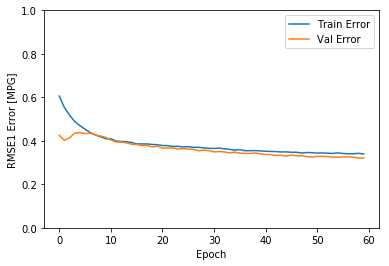

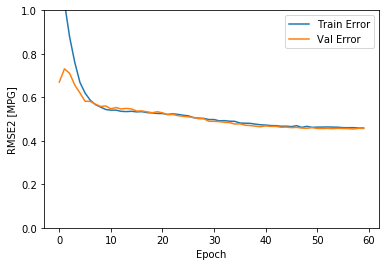

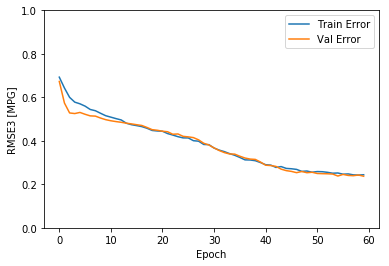

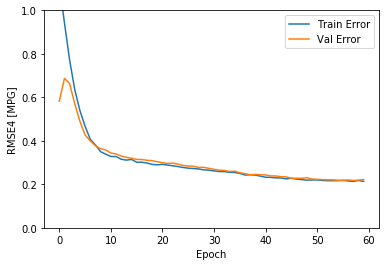

In [251]:
plot_history(history)

In [252]:
total_predict = model.predict(X_test)

In [253]:
len(total_predict[0])

857

# Converting output to Trip

From Predicted Longitude/ Lattitude to Destination

From Predicted Days from 1/1/2015 to Departure Date

From Predicted stay to Return Date

In [254]:
pred_days = [l[0] for l in total_predict[0]]
pred_stay =  [l[0] for l in total_predict[1]]
pred_latti =  [l[0] for l in total_predict[2]]
pred_longi =  [l[0] for l in total_predict[3]]


In [255]:
len(pred_days)

857

In [256]:
pred_output = pd.DataFrame({'days':pred_days,'stay':pred_stay,'latti':pred_latti,'longi':pred_longi})

In [257]:
pred_output.shape

(857, 4)

In [258]:
Scaled_Output = scaler_output.inverse_transform(pred_output)

In [259]:
Scaled_Output_df = pd.DataFrame(Scaled_Output, columns = ['days','stay','latti','longi'])

In [260]:
Scaled_Output_df.shape

(857, 4)

In [261]:
Scaled_Output_df.head()

,days,stay,latti,longi
0,1102.000000,55.964053,35.260099,-73.051314
1,1418.520873,65.665090,34.451314,-64.881461
2,1102.000000,61.374283,35.224690,-66.642562
3,1318.894901,13.457069,-53.002602,-159.339005
4,1444.686779,0.000000,-53.002602,-159.339005


In [262]:
Scaled_Output_df['stay'].describe()

count    857.000000
mean      60.317675
std       19.033360
min        0.000000
25%       62.367219
50%       65.668571
75%       65.714133
max      126.591873
Name: stay, dtype: float64

Find closest airport

In [263]:
def get_airport(x):
    lat = x['latti']
    long = x['longi']
    min_dis = 1000000
    port = 'Random'
    for row,_ in airport.iterrows():
        lat_row = airport.loc[row,'latitude']
        long_row = airport.loc[row,'longitude']
        
        dis = (lat_row - lat)**2 +  (long_row - long)**2
        
        if min_dis > dis:
            min_dis = dis
            
            port = airport.loc[row,'location_id']
        
    return port   

In [264]:
Scaled_Output_df['Nearest_Destination'] = Scaled_Output_df.apply(get_airport,axis=1)

In [265]:
def get_departure_date (x):
    y = int(x)    
    val = pd.to_datetime('1/1/2015', format='%m/%d/%Y') + np.timedelta64(y,'D')
    return val

In [266]:
Scaled_Output_df['Approx_Departure_Date'] = Scaled_Output_df['days'].apply(get_departure_date)

In [267]:
Scaled_Output_df['Approx_Departure_Date'].head()

0   2018-01-07
1   2018-11-19
2   2018-01-07
3   2018-08-11
4   2018-12-15
Name: Approx_Departure_Date, dtype: datetime64[ns]

In [268]:
def get_return_date (x):
    departure = x['Approx_Departure_Date']
    stay = int(x['stay'])
    
    if stay >= 65:
        return 
    else:
        y = stay//7
        val = pd.to_datetime(departure, format='%y-%m-%d') + np.timedelta64(y,'D')
        return val

In [269]:
Scaled_Output_df['Approx_Reurn_Date'] = Scaled_Output_df.apply(get_return_date, axis=1)

In [270]:
Scaled_Output_df['Approx_Reurn_Date'] .head()

0   2018-01-14
1          NaT
2   2018-01-15
3   2018-08-12
4   2018-12-15
Name: Approx_Reurn_Date, dtype: datetime64[ns]

In [271]:
Scaled_Output_df.head()

,days,stay,latti,longi,Nearest_Destination,Approx_Departure_Date,Approx_Reurn_Date
0,1102.000000,55.964053,35.260099,-73.051314,airport/HNC,2018-01-07,2018-01-14
1,1418.520873,65.665090,34.451314,-64.881461,airport/BDA,2018-11-19,NaT
2,1102.000000,61.374283,35.224690,-66.642562,airport/BDA,2018-01-07,2018-01-15
3,1318.894901,13.457069,-53.002602,-159.339005,airport/CHT,2018-08-11,2018-08-12
4,1444.686779,0.000000,-53.002602,-159.339005,airport/CHT,2018-12-15,2018-12-15


In [225]:
Scaled_Output_df[pd.isnull(Scaled_Output_df['Approx_Reurn_Date'])].shape

(494, 7)

# Converting Y_test back to trip form

In [227]:
Y_test_unscaled = scaler_output.inverse_transform(Y_test)

In [228]:
Y_test_unscaled_df = pd.DataFrame(Y_test_unscaled, columns = ['departure_date_from_2015','stay_y','latitude_destination','longitude_destination'])

In [229]:
Y_test_unscaled_df.head()

,departure_date_from_2015,stay_y,latitude_destination,longitude_destination
0,1505.0,4.0,28.429399,-81.308998
1,1450.0,8.0,36.124500,-86.678200
2,1121.0,3.0,36.080101,-115.152000
3,1459.0,200.0,26.072599,-80.152702
4,1294.0,200.0,37.618999,-122.375000


In [230]:
Actual_Output = Y_test_unscaled_df.merge(airport[['latitude','longitude','location_id']], left_on=['latitude_destination','longitude_destination'], right_on=['latitude','longitude'])

In [231]:
Actual_Output.head()

,departure_date_from_2015,stay_y,latitude_destination,longitude_destination,latitude,longitude,location_id
0,1450.0,8.0,36.1245,-86.6782,36.1245,-86.6782,airport/BNA
1,1450.0,8.0,36.1245,-86.6782,36.1245,-86.6782,airport/BNA
2,1476.0,5.0,36.1245,-86.6782,36.1245,-86.6782,airport/BNA
3,1169.0,2.0,36.1245,-86.6782,36.1245,-86.6782,airport/BNA
4,1296.0,2.0,36.1245,-86.6782,36.1245,-86.6782,airport/BNA


In [232]:
Y_test_unscaled_df['Destination'] = Actual_Output['location_id']

In [233]:
Y_test_unscaled_df['Deaprture_date'] = Y_test_unscaled_df['departure_date_from_2015'].apply(get_departure_date)

In [234]:
def get_return_date_actual (x):
    departure = x['Deaprture_date']
    stay = int(x['stay_y'])
    
    if stay >= 200:
        return 
    else:
        
        val = pd.to_datetime(departure, format='%y-%m-%d') + np.timedelta64(stay,'D')
        return val

In [235]:
Y_test_unscaled_df['Return_Date'] = Y_test_unscaled_df.apply(get_return_date_actual,axis=1)

In [236]:
Y_test_unscaled_df.head()

,departure_date_from_2015,stay_y,latitude_destination,longitude_destination,Destination,Deaprture_date,Return_Date
0,1505.0,4.0,28.429399,-81.308998,airport/BNA,2019-02-14,2019-02-18
1,1450.0,8.0,36.124500,-86.678200,airport/BNA,2018-12-21,2018-12-29
2,1121.0,3.0,36.080101,-115.152000,airport/BNA,2018-01-26,2018-01-29
3,1459.0,200.0,26.072599,-80.152702,airport/BNA,2018-12-30,NaT
4,1294.0,200.0,37.618999,-122.375000,airport/BNA,2018-07-18,NaT


In [237]:
tmp = Y_test_unscaled_df.merge(airport[['location_id','airport_group']], left_on='Destination', right_on='location_id')

In [238]:
Y_test_unscaled_df['destination_gp'] = tmp['airport_group']

In [239]:
Y_test_unscaled_df.shape, Scaled_Output_df.shape

((857, 8), (857, 7))

In [281]:
Y_test_unscaled_df[pd.isnull(Y_test_unscaled_df['Return_Date'])].shape

(266, 8)

In [272]:
tmp = Scaled_Output_df.merge(airport[['location_id','airport_group']], left_on='Nearest_Destination', right_on='location_id')

In [273]:
Scaled_Output_df['destination_gp'] = tmp['airport_group']

In [274]:
c=0
for row,_ in Y_test_unscaled_df.iterrows():
    if Y_test_unscaled_df.loc[row,'destination_gp'] == Scaled_Output_df.loc[row,'destination_gp']:
        c += 1
    

In [191]:
c=0
for row,_ in Y_test_unscaled_df.iterrows():
    if abs(Y_test_unscaled_df.loc[row,'Deaprture_date'] - Scaled_Output_df.loc[row,'Approx_Departure_Date']).days < 30:
        c += 1
c    

84

In [192]:
c=0
for row,_ in Y_test_unscaled_df.iterrows():
    if Y_test_unscaled_df.loc[row,'stay_y'] >= 200 and Scaled_Output_df.loc[row,'stay'] > 65:
        c += 1
c    

214

In [278]:
Scaled_Output_df.head()

,days,stay,latti,longi,Nearest_Destination,Approx_Departure_Date,Approx_Reurn_Date,destination_gp
0,1102.000000,55.964053,35.260099,-73.051314,airport/HNC,2018-01-07,2018-01-14,airport/HNC
1,1418.520873,65.665090,34.451314,-64.881461,airport/BDA,2018-11-19,NaT,airport/HNC
2,1102.000000,61.374283,35.224690,-66.642562,airport/BDA,2018-01-07,2018-01-15,airport/HNC
3,1318.894901,13.457069,-53.002602,-159.339005,airport/CHT,2018-08-11,2018-08-12,airport/HNC
4,1444.686779,0.000000,-53.002602,-159.339005,airport/CHT,2018-12-15,2018-12-15,airport/HNC
